In [3]:
import numpy as np
import uproot as up
import awkward as ak
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import MuonAnalysis

In [4]:
import os
fpath = 'map.root'
run = up.open(fpath)
print(len(run))
keys = np.array(run.keys())

251


In [5]:
import re
from collections import defaultdict
index_id = defaultdict(list)

N_steps = int((len(keys)-2)/3)

def gaussian(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

histl = []
histt = []
tracks = []
params = []
max_steps = 0
pattern = re.compile(r'ProftTrack_(\d+)_(\d+)')
image_index = []
cluster_index = []

for i in range(N_steps):
    transversal = run[ keys[i*3] ].to_numpy()
    longitudinal = run[ keys[i*3 + 1] ].to_numpy()
    track = run[keys[i*3 + 2]].values().T
    
    if (np.any(transversal[0])) & (np.any(longitudinal[0])):    #& (np.max(transversal[0]) > 2500 )
        histt.append(transversal)
        histl.append(longitudinal)
        tracks.append(track)
        popt, pcov = curve_fit(gaussian, transversal[1][:-1], transversal[0])
        params.append(popt)
        max_steps += 1
        
        match = pattern.match(keys[i*3])
        if match:
            img_idx = int(match.group(1))
            clus_idx = int(match.group(2))
            image_index.append(img_idx)
            cluster_index.append(clus_idx)
            index_id[img_idx].append(clus_idx)

print('the max index is =', len(tracks)-1)

#of the params we have the first which is the amplitude of the gaussian that we don't care abt, then the mu, even less useful and finally the sigma

the max index is = 71


In [6]:
def plotter (index):
    print(keys[index*3])
    print(keys[index*3 +1])
    print(keys[index*3 +2])
    
    fig, ax = plt.subplots(1,3, figsize=(15, 6))
    ax[0].step(histl[index][1][:-1], histl[index][0])
    ax[0].set_title('Longitudinal profile')
    
    ax[1].step(histt[index][1][:-1], histt[index][0])
    ax[1].plot(histt[index][1][:-1], gaussian(histt[index][1][:-1], params[index][0], params[index][1], params[index][2]))
    ax[1].set_title('Transversal profile')
    
    ax[2].imshow(tracks[index])
    ax[2].set_title('Reduced track')
    ax[2].set_xlabel('x pixel')
    ax[2].set_ylabel('y pixel')
    plt.show()

# track 70 is clearly an electron
# also track 10

In [7]:
# now first I compute the average sigma and summed histogram for the psf

sigma = []
x = []
y = []

for i in range(len(params)):
    sigma.append( np.abs(params[i][2]) )
    x = histt[i][1][:-1] - params[i][1]
    y = histt[i][0]/np.trapz(histt[i][0])
    

print('the average sigma is: ', np.mean(sigma))

the average sigma is:  9.09214011176999


<function matplotlib.pyplot.show(close=None, block=None)>

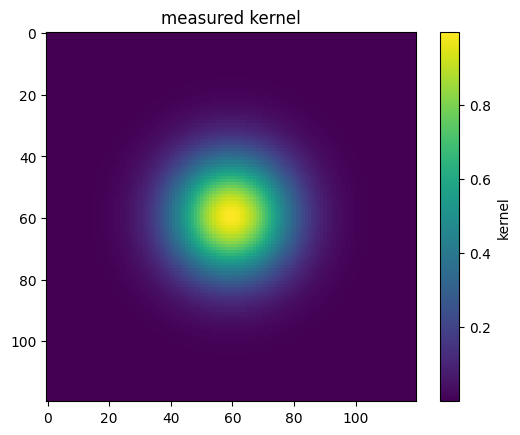

In [8]:
# with this I can construct a better kernel first for the psf

t = np.linspace(-40, 40, 120)
vec = gaussian(t, 1, 0, np.mean(sigma))
ker = np.outer(vec, vec)

plt.imshow(ker)
plt.colorbar(label='kernel')
plt.title('measured kernel')
plt.show


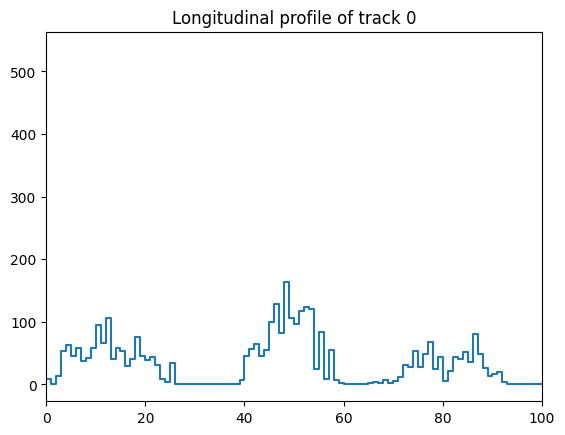

In [16]:
# now if the peaks are actually due to primary electrons produced by the muon and after the amplification the number
# of electrons produced is truly proportional to the number of primary electrons then the peaks should be some integer
# number of times larger than the smallest peak

#first plot a sample longitudinal histogram

plt.step(histl[0][1][:-1], histl[0][0])
plt.title('Longitudinal profile of track 0')
plt.xlim(0, 100)
plt.show()

# In order to find how many primary electrons are produced in the track what I will do is 
# I will create a function to scan the whole profile to look for starting indices, final indices
# and the number of clusters and then compute the integral. The function will return x_start, x_end, n_clust, clust_int

def nFinder (x, y, sens):
    x_start = []
    x_end = []
    n_clust = 0
    clust_int = []
    width = x[1:] - x[:-1]
    # searching is true if a cluster is not yet found
    searching = True
    for xbin in range(len(y)):
        if (searching) & (y[xbin] > sens):
            #print('starting with cluster:', n_clust)
            x_start.append(x[xbin])
            integral = 0
            searching = False
            
        if (searching == False):
            integral += width[xbin]*y[xbin]
            
        if (searching == False) & (y[xbin] < sens):
            # check that the three consecutive bins are also below threshold
            # and also check that you are not at the end of the array bc then there is no reason to do it
            if (xbin < len(y)-4):
                if (y[xbin + 1] < sens) & (y[xbin + 2] < sens) & (y[xbin + 3] < sens):
                    x_end.append(x[xbin])
                    n_clust += 1
                    clust_int.append(integral)
                    searching = True

    if searching == False:
        x_end.append(x[len(y)-1])
    #print('The number of clusters found is:', n_clust)
    #print('Is the len of x_start and x_end the same?', len(x_start)==len(x_end))
    return np.array(x_start), np.array(x_end), np.array(clust_int), n_clust

In [20]:
starts = []
ends = []
cintegrals = []
nclusters = []
cmin = []
cratio = []
min_light = 2

for i in range( len(tracks) ):
    x_start, x_end, cluster_int, n_clusters = nFinder(histl[i][1], histl[i][0], min_light)
    starts.append(x_start)
    ends.append(x_end)
    cintegrals.append(cluster_int)
    nclusters.append(n_clusters)
    cmin.append( np.min(cluster_int) )
    cratio.append(cluster_int/(np.min(cluster_int)) )

[7.56190462e+02 8.16190463e+01 9.28571392e+00 1.96142853e+02
 7.26642843e+02 6.47142843e+01 2.10754758e+03 2.77261900e+02
 3.66666659e+00 2.21642853e+02 1.00000000e+00 5.15523800e+02
 1.90499997e+02 2.05257139e+03 2.77176186e+03 3.20226184e+03
 1.09149998e+03 9.78952363e+02 7.35119034e+02 7.35476179e+01
 2.24857138e+02 1.29285712e+02 5.12380941e+02 1.20476187e+01
 2.96904756e+02 1.37023807e+02]


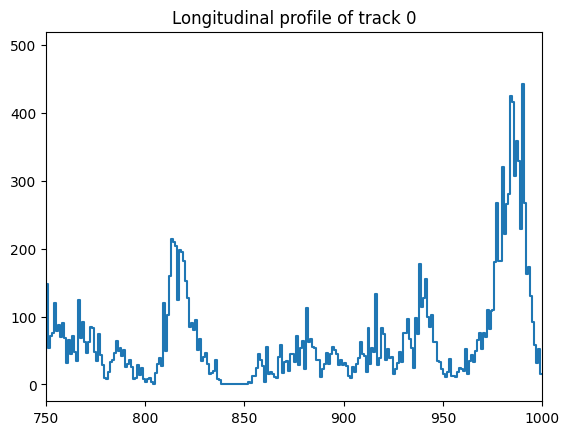

ProftTrack_28_4;1
ProflTrack_28_4;1
Track_28_4_74_delta408_size43;1


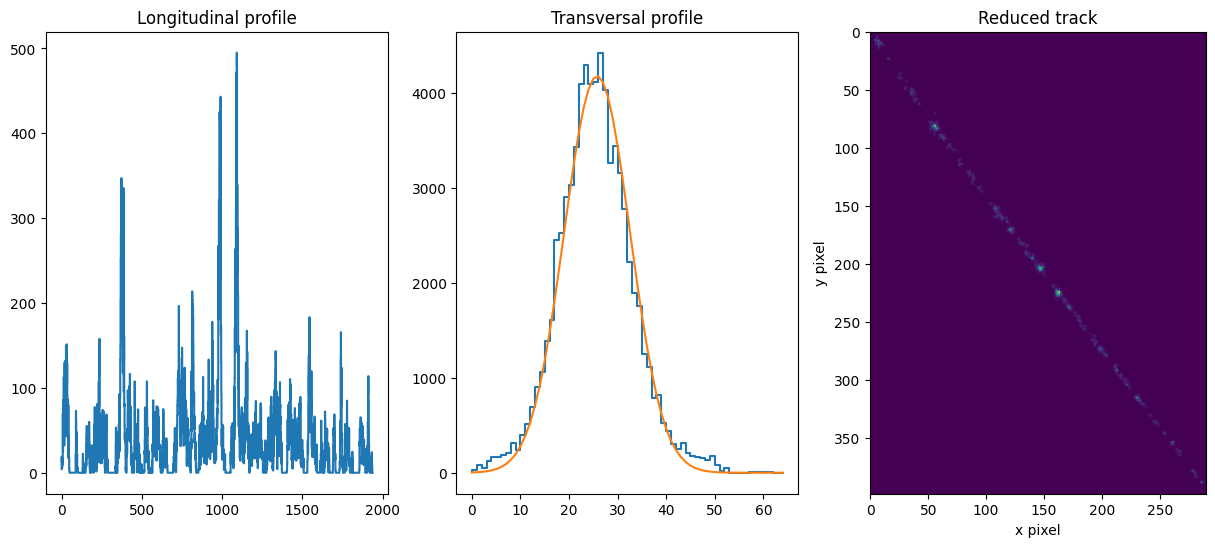

In [36]:
print(cratio[12])
plt.step(histl[12][1][:-1], histl[12][0])
plt.title('Longitudinal profile of track 0')
plt.xlim(750, 1e3)
plt.show()
plotter(12)

In [135]:
# this calculation gives an estimate of how many electrons I expect for a pixel

# the w for the gas is 35ev while if the muon is a MIP then it releases 2000 eV/cm in the gas itself

w = 35
mu_energy_density = 2000

electron_density = mu_energy_density/w

# this gives about 57 electrons per cm, if I want to convert this in pixels, considering each pixel is 50um we get

# now 1cm / 50um gives 200 so each cm is a 200px region

# to estimate how many electrons I expect in each cm I can calculate 200/57 which gives about 4 pixels
# so I expect an electron each 4 pixels.

ProftTrack_181_1;1
ProflTrack_181_1;1
Track_181_1_22_delta359_size43;1


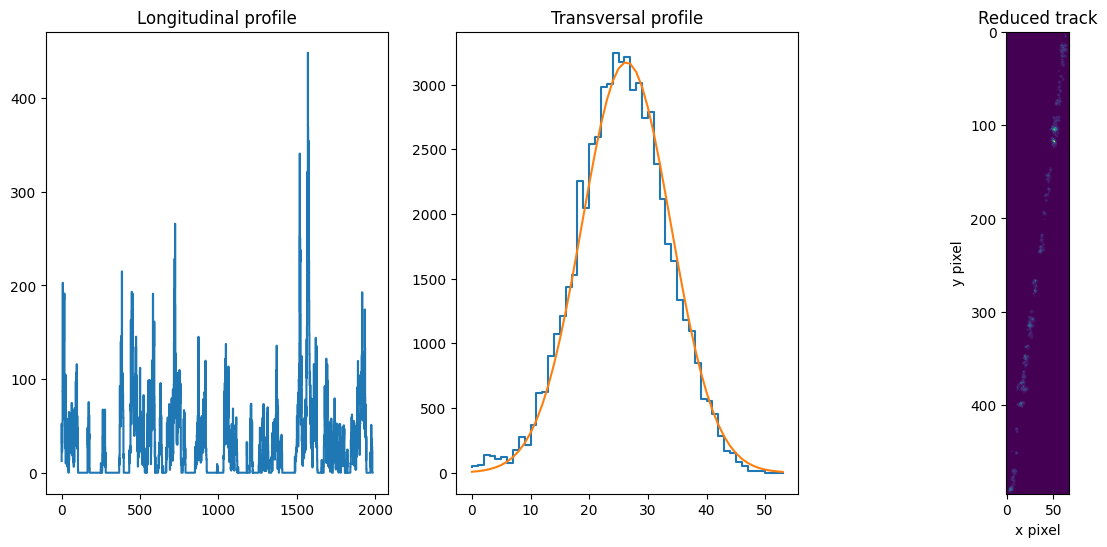

In [147]:
# electron recoils tracks
# note that track 70 is an electron
# ProftTrack_15_0;1 (4)
# ProftTrack_26_3;1 (11)
# ProftTrack_99_3;1 (32)
# ProftTrack_135_1;1 (43)
# ProftTrack_136_0;1 (44)
# ProftTrack_165_5;1 (57)
# ProftTrack_181_0;1 (70)